# Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('white')

In [3]:
orders = pd.read_csv("data/orders.csv").drop(
    ["index", "order_approved_at", "order_delivered_carrier_date"], axis=1
)
payments = pd.read_csv("data/payments.csv").drop(
    ["index", "payment_installments", "payment_sequential", "payment_type"], axis=1
)
reviews = pd.read_csv("data/reviews.csv").drop(
    [
        "index",
        "review_id",
        "review_answer_timestamp",
        "review_comment_title",
        "review_comment_message",
        "review_creation_date",
    ],
    axis=1,
)
customers = pd.read_csv("data/customers.csv").drop(
    ["index", "customer_state", "customer_zip_code_prefix", "customer_city"], axis=1
)

# Outer join

In [4]:
df = (
    orders.merge(payments, how="outer", on="order_id")
    .merge(reviews, how="outer", on="order_id")
    .merge(customers, how="outer", on="customer_id")
).drop("customer_id", axis=1)

df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.12,4.0,7c396fd4830fd04220f754e42b4e5bff
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,2.00,4.0,7c396fd4830fd04220f754e42b4e5bff
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,4.0,7c396fd4830fd04220f754e42b4e5bff
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,4.0,af07308b275d755c9edb36a90c618231
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8


In [5]:
df.sort_values('order_purchase_timestamp')

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id
4751,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,NaN,2016-10-20 00:00:00,136.23,1.0,b7d76e111c89f7ebf14761390f0f7d17
4606,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,NaN,2016-10-28 00:00:00,75.06,1.0,4854e9b3feff728c13ee5fc7d1547e92
10589,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-09-13 15:24:19,NaN,2016-09-30 00:00:00,40.95,1.0,009b0127b727ab0ba422f6d9604487c7
32304,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23
87261,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,NaN,2016-10-25 00:00:00,109.34,1.0,0eb1ee9dba87f5b36b4613a65074337c
...,...,...,...,...,...,...,...,...
52976,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,NaN,2018-10-15 00:00:00,137.03,1.0,9bb92bebd4cb7511e1a02d5e50bc4655
92952,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,NaN,2018-10-23 00:00:00,80.38,2.0,634420a0ea42302205032ed44ac7fccc
33553,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,NaN,2018-10-16 00:00:00,197.55,1.0,af5454198a97379394cacf676e1e96cb
71772,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,NaN,2018-11-12 00:00:00,222.03,5.0,262e1f1e26e92e86375f86840b4ffd63


# Conversion datetime

In [6]:
for dt in [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]:
    df[dt] = pd.to_datetime(df[dt])

# EDA

<Axes: >

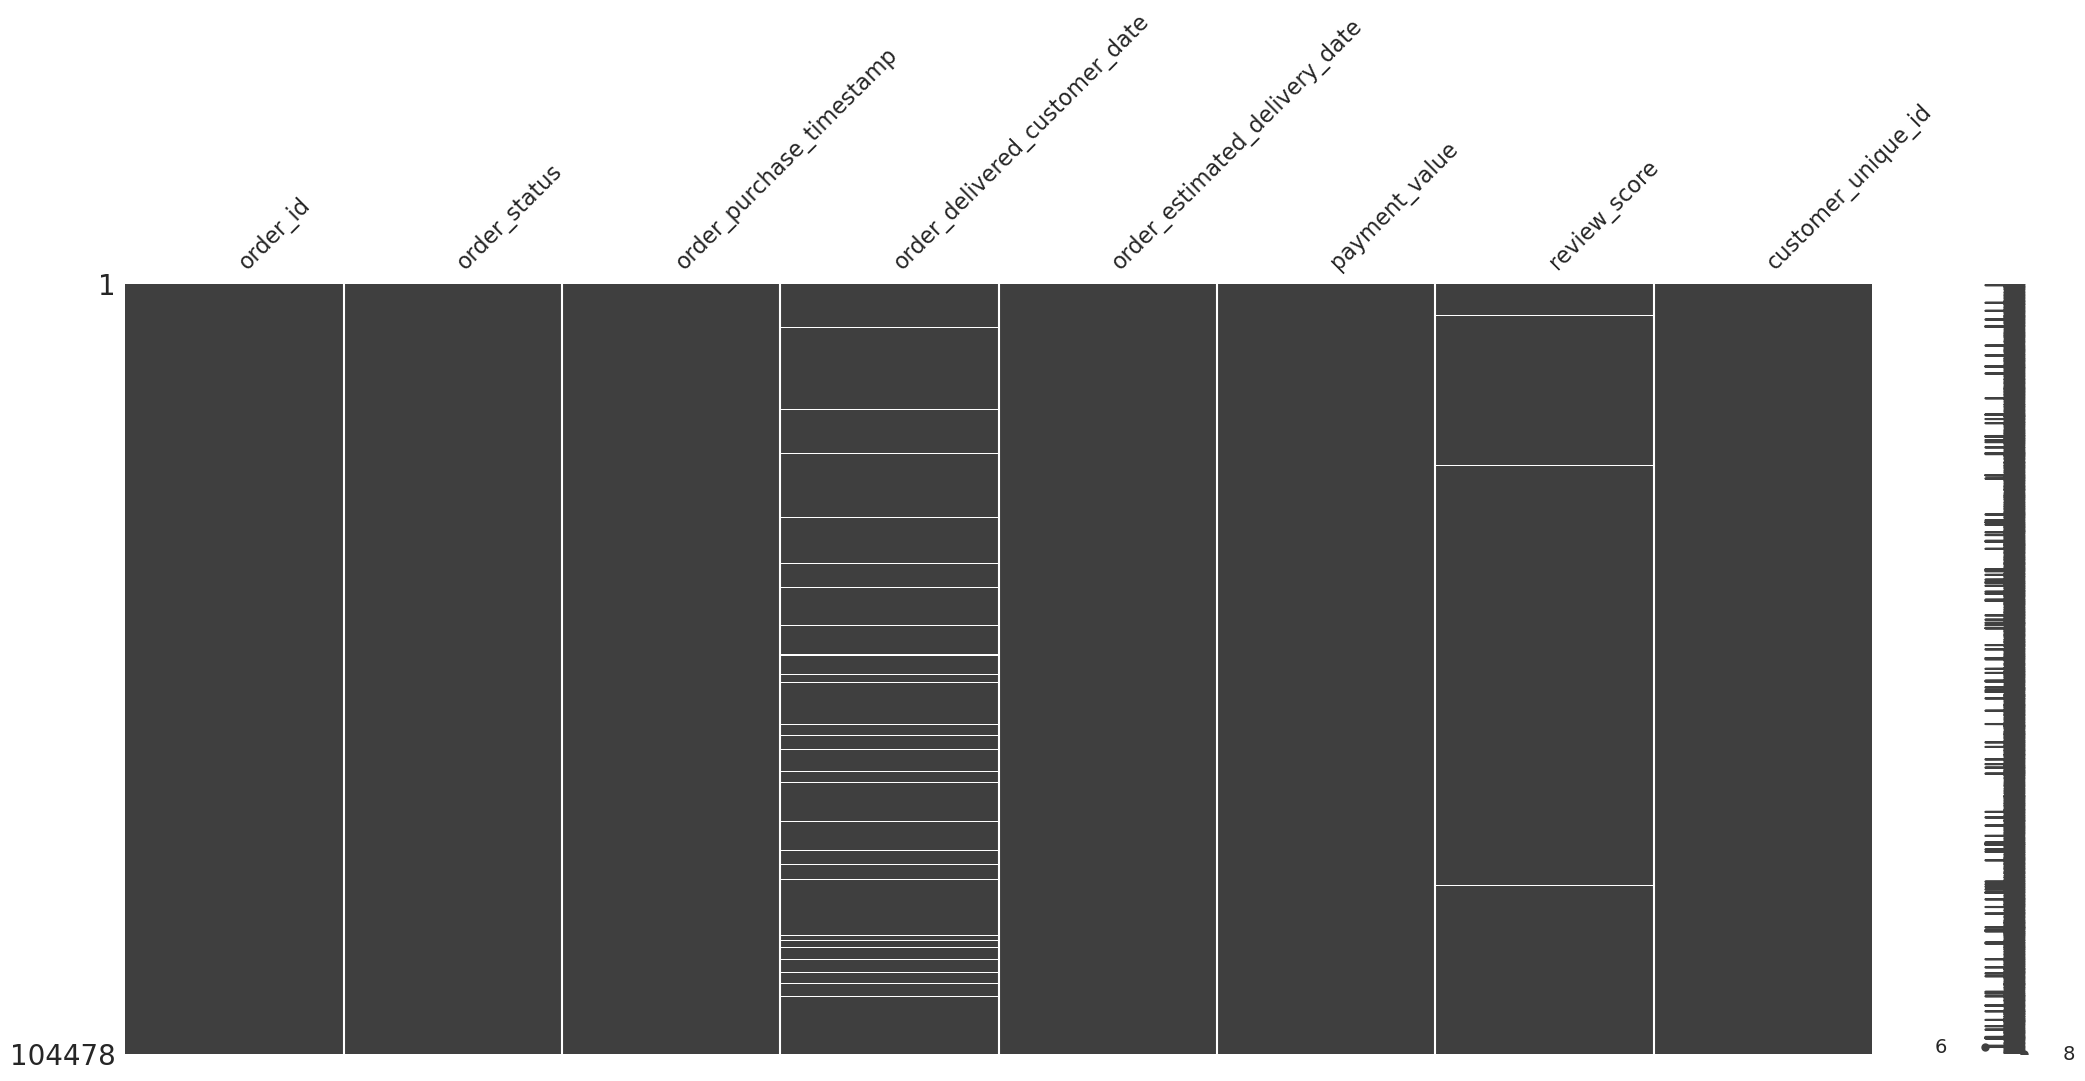

In [7]:
mno.matrix(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104478 entries, 0 to 104477
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       104478 non-null  object        
 1   order_status                   104478 non-null  object        
 2   order_purchase_timestamp       104478 non-null  datetime64[ns]
 3   order_delivered_customer_date  101324 non-null  datetime64[ns]
 4   order_estimated_delivery_date  104478 non-null  datetime64[ns]
 5   payment_value                  104477 non-null  float64       
 6   review_score                   103678 non-null  float64       
 7   customer_unique_id             104478 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(3)
memory usage: 6.4+ MB


### Orders analysis

/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


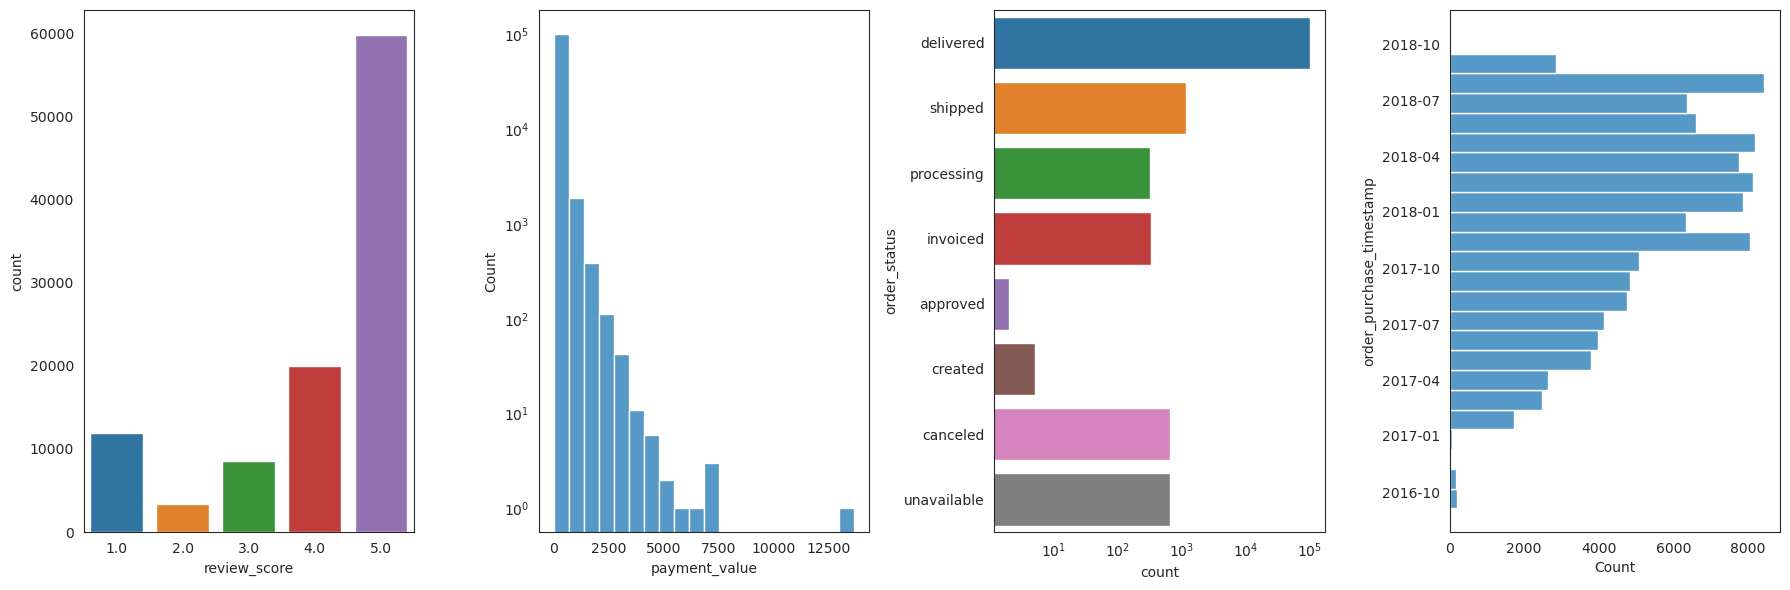

In [17]:
fig = plt.figure(figsize=(18, 6))

fig.add_subplot(141)
sns.countplot(data=df, x="review_score")

fig.add_subplot(142)
sns.histplot(data=df, x="payment_value", bins=20)
plt.yscale("log")

fig.add_subplot(143)
sns.countplot(
    data=df,
    y="order_status",
    order=[
        "delivered",
        "shipped",
        "processing",
        "invoiced",
        "approved",
        "created",
        "canceled",
        "unavailable",
    ],
)
plt.xscale("log")

fig.add_subplot(144)
sns.histplot(data=df, y="order_purchase_timestamp", bins=24)

plt.tight_layout()

# Feature Engineering

## Missing payment imputation

In [18]:
df.loc[df["payment_value"].isna(), "payment_value"] = 0

## Addtitional features

### Delay

In [19]:
NOW = df["order_purchase_timestamp"].value_counts().sort_index(ascending=False).index[0]

In [20]:
# Delay = time between the estimated delivery date and the actual delivery date
df["delay"] = df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]

# Delay = time between now and the estimated delivery date, or 0 if the estimated delivery date is in the future
delay_pending = (NOW - df["order_estimated_delivery_date"]).where(
    NOW - df["order_estimated_delivery_date"] > pd.Timedelta(0), pd.Timedelta(0)
)

# Mask for orders not yet delivered
mask_pending = pd.isnull(df["order_delivered_customer_date"])
df.loc[mask_pending, "delay"] = df["delay"].combine_first(delay_pending)

# Delay = 0 for canceled and unavailable orders
mask_canceled_unavailable = df["order_status"].isin(["canceled", "unavailable"])
df.loc[mask_canceled_unavailable, "delay"] = pd.Timedelta(0)

### Time since order

In [21]:
df["time_since_order"] = NOW - df["order_purchase_timestamp"]

In [22]:
df

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id,delay,time_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.12,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2.00,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.59,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,141.46,4.0,af07308b275d755c9edb36a90c618231,-6 days +15:27:45,84 days 20:48:41
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8,-18 days +18:06:29,70 days 08:51:29
...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,85.08,5.0,6359f309b166b0196dbf7ad2ac62bb5a,-11 days +15:08:01,587 days 07:36:13
104474,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,195.00,4.0,da62f9e57a76d978d02ab5362c509660,-2 days +17:37:56,253 days 04:31:20
104475,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,271.01,5.0,737520a9aad80b3fbbdad19b66b37b30,-6 days +11:24:17,416 days 02:43:35
104476,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,441.16,2.0,5097a5312c8b157bb7be58ae360ef43c,-21 days +23:32:54,281 days 20:01:51


## Group by "order_id"

In [23]:
df_agg_order = (
    df.groupby("order_id")
    .agg(
        {
            "customer_unique_id": "first",
            "payment_value": "sum",
            "review_score": "mean",
            "time_since_order": "first",
            "delay": "max",

        }
    )
    .reset_index()
)

In [24]:
df_agg_order.columns = ["order_id", "customer_unique_id", "total_payments", "mean_review_score", "time_since_order", "delay"]

In [25]:
df_agg_order.sort_values("time_since_order")

,order_id,customer_unique_id,total_payments,mean_review_score,time_since_order,delay
6511,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,89.71,1.0,0 days 00:00:00,0 days 00:00:00
68317,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,222.03,5.0,0 days 21:14:16,0 days 00:00:00
62892,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,197.55,1.0,13 days 22:34:49,0 days 00:00:00
37735,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,80.38,2.0,16 days 02:00:09,0 days 00:00:00
22190,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,137.03,1.0,18 days 08:17:15,0 days 00:00:00
...,...,...,...,...,...,...
43966,71303d7e93b399f5bcd537d124c0bcfa,0eb1ee9dba87f5b36b4613a65074337c,109.34,1.0,744 days 19:22:26,0 days 00:00:00
74448,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,0.00,1.0,762 days 05:13:40,36 days 07:47:38
49869,809a282bbd5dbcabb6f2f724fca862ec,009b0127b727ab0ba422f6d9604487c7,40.95,1.0,764 days 02:05:59,0 days 00:00:00
89489,e5fa5a7210941f7d56d0208e4e071d35,4854e9b3feff728c13ee5fc7d1547e92,75.06,1.0,772 days 17:14:44,0 days 00:00:00


In [26]:
df_agg_order.to_json('orders.json')

## Group by "customer_id"

In [27]:
df_agg_customer = df_agg_order.groupby("customer_unique_id").agg(
    {
        "order_id": "count",
        "total_payments": "sum",
        "mean_review_score": "mean",
        "time_since_order": "min",
        "delay": "mean",
    }
)

df_agg_customer.columns = [
    "n_orders",
    "total_payments",
    "mean_review_score",
    "time_since_order",
    "mean_delay",
]

In [28]:
df_agg_customer

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,5.0,160 days 06:33:51,-5 days +20:48:37
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,4.0,163 days 06:18:51,-5 days +18:02:42
0000f46a3911fa3c0805444483337064,1,86.22,3.0,585 days 20:25:15,-2 days +14:38:47
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,4.0,369 days 21:00:37,-12 days +21:23:05
0004aac84e0df4da2b147fca70cf8255,1,196.89,5.0,336 days 21:44:36,-8 days +23:08:56
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,5.0,495 days 20:29:42,-27 days +09:22:00
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,4.0,310 days 21:22:22,-3 days +22:28:20
ffff371b4d645b6ecea244b27531430a,1,112.46,5.0,617 days 01:41:02,-30 days +12:45:04


## Imputation and standardization

In [29]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

df_stantardized = df_agg_customer.copy()

In [30]:
# Impute mean value to review score
df_stantardized["mean_review_score"] = imputer.fit_transform(
    np.array(df_stantardized["mean_review_score"]).reshape(-1, 1)
)

In [31]:
# Convert datetime to seconds
df_stantardized[["time_since_order", "mean_delay"]] = (
    df_stantardized[["time_since_order", "mean_delay"]]
    .map(lambda cell: cell.total_seconds())
)

In [32]:
# Log tranform
df_stantardized[["n_orders", "total_payments"]] = (
    df_stantardized[["n_orders", "total_payments"]]
    .map(lambda cell: np.log1p(cell))
)

In [33]:
# Standardization
for col in df_stantardized.columns:
    df_stantardized[col] = scaler.fit_transform(
        np.array(df_stantardized[col]).reshape(-1, 1)
    )

/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/victorien/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

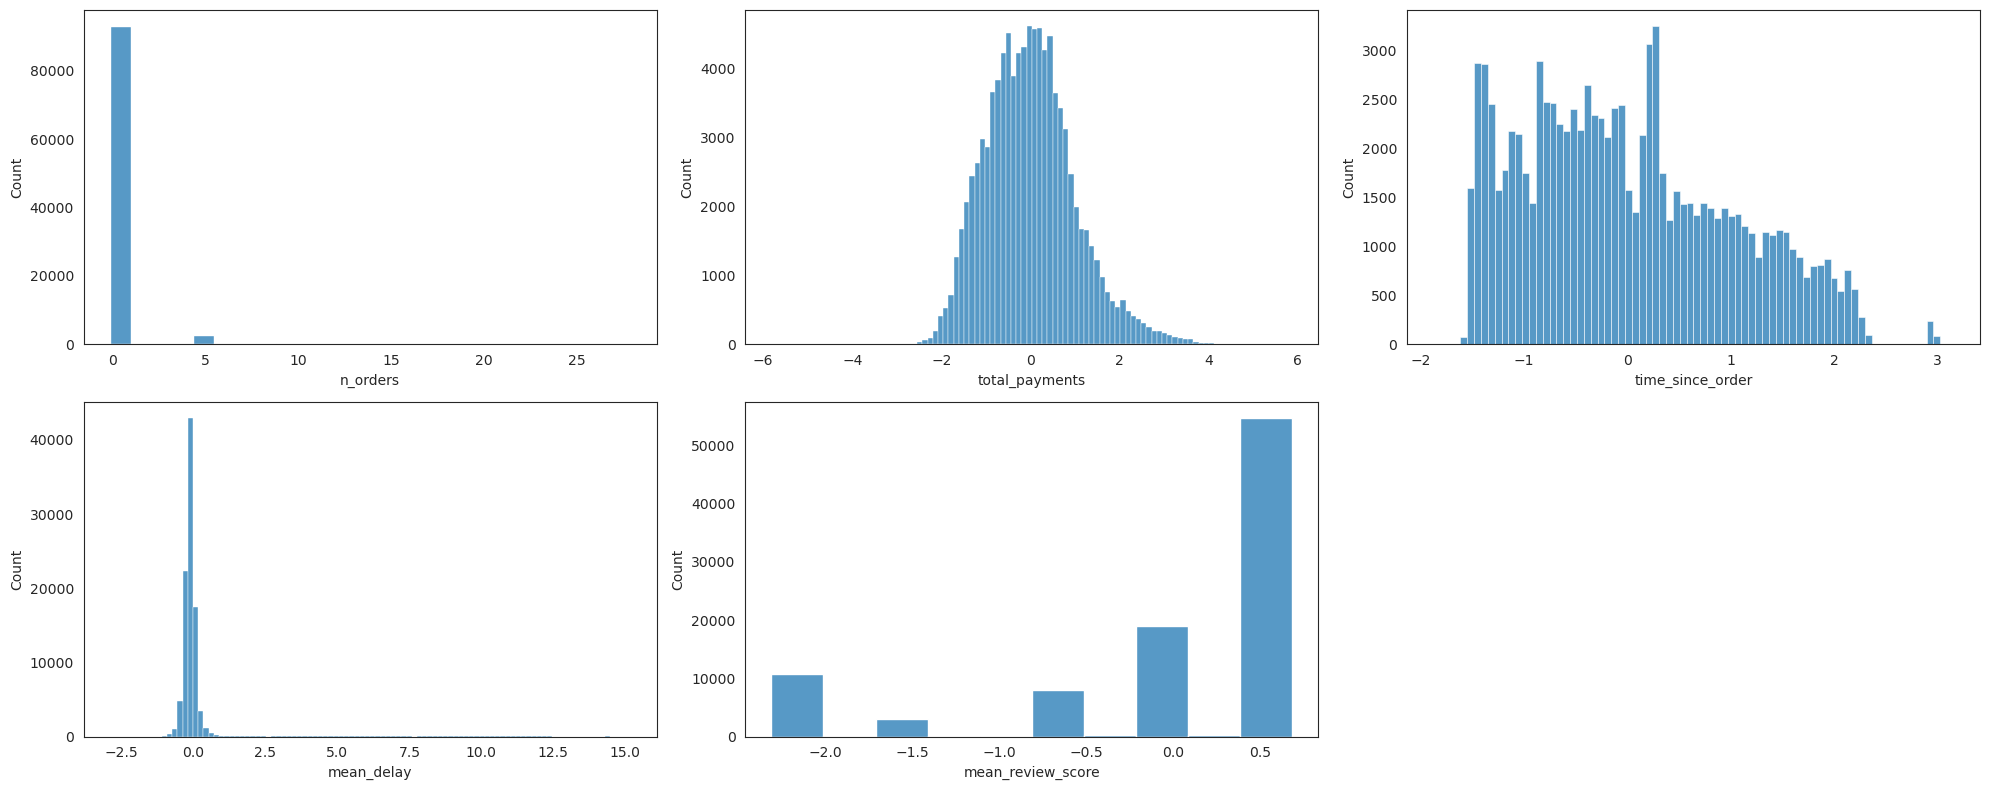

In [46]:
fig = plt.figure(figsize=(20,8))

fig.add_subplot(231)
sns.histplot(df_stantardized["n_orders"], bins=25)

fig.add_subplot(232)
sns.histplot(df_stantardized["total_payments"], bins=100)

fig.add_subplot(233)
sns.histplot(df_stantardized["time_since_order"])

fig.add_subplot(234)
sns.histplot(df_stantardized["mean_delay"], bins=100)

fig.add_subplot(235)
sns.histplot(df_stantardized["mean_review_score"], bins=10)

plt.tight_layout()

In [35]:
df_stantardized

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.173593,0.278509,0.684576,-0.833865,0.025207
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.173593,-1.715381,-0.063565,-0.814378,0.022821
0000f46a3911fa3c0805444483337064,-0.173593,-0.327960,-0.811705,1.940152,0.082023
0000f6ccb0745a6a4b88665a16c9f078,-0.173593,-1.151287,-0.063565,0.532372,-0.119279
0004aac84e0df4da2b147fca70cf8255,-0.173593,0.678430,0.684576,0.317469,-0.034910
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,-0.173593,3.561242,0.684576,1.353531,-0.440327
fffea47cd6d3cc0a88bd621562a9d061,-0.173593,-0.351277,-0.063565,0.147894,0.068065
ffff371b4d645b6ecea244b27531430a,-0.173593,-0.004874,0.684576,2.143647,-0.499541


In [36]:
df_stantardized.to_json('data.json')